In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray as xr
import xbout
from pathlib import Path

onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from code_comparison.code_comparison import *

%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Done


# Intro
- This is for running test cases on a lo res case from scratch 

In [2]:
casestore = dict()

In [3]:
db = CaseDB(case_dir = os.path.join(onedrive_path, r"Project\collab\tech\cases"),
            grid_dir = os.path.join(onedrive_path, r"Project\collab\tech\grid"))

toload = [
    dict(name="cvode", id="x3a2-post_1D_fixes", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    dict(name="beuler", id="x3a3-post_1D_fixes_beuler", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.607E+00 [m3]
CHECK: Total domain volume is 1.607E+00 [m3]


## Residuals

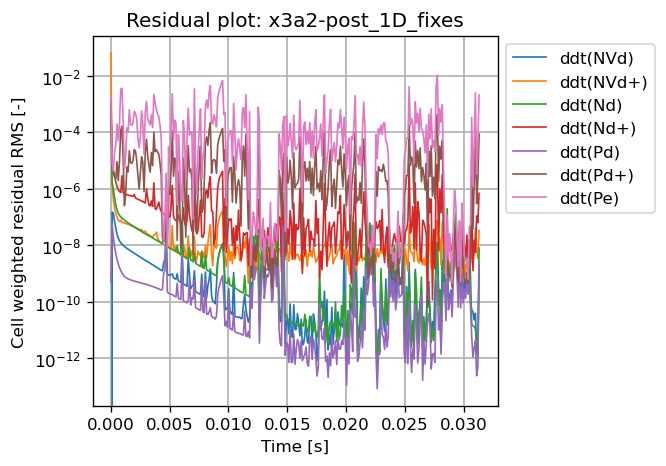

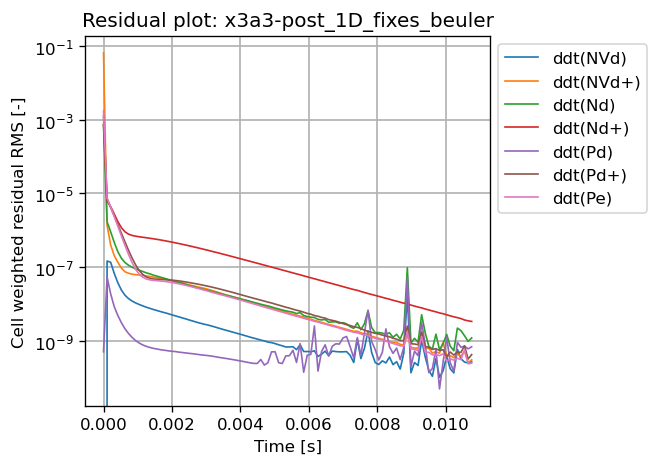

In [6]:
for i, case in enumerate(toload):
    plot_ddt(casestore[case["name"]])
    # , ylims = (1e-14, 1e-2), xlims = (0,0.05))

In [7]:
hr = dict()
for hermes_case in casestore.keys():
    print(hermes_case)
    hr[hermes_case] = Hermesdata()

    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

cvode
beuler


In [10]:
from code_comparison.viewer_2d import *

In [12]:
plt.close("all")
%matplotlib inline

In [ ]:
cases["x3a1"]

In [11]:
casestore.keys()

dict_keys(['base', 'fixes_minmod', 'fixes_mc', 'fixes_noslopereac'])

# Runtime metrics

Text(0.5, 1.0, 'Runtime')

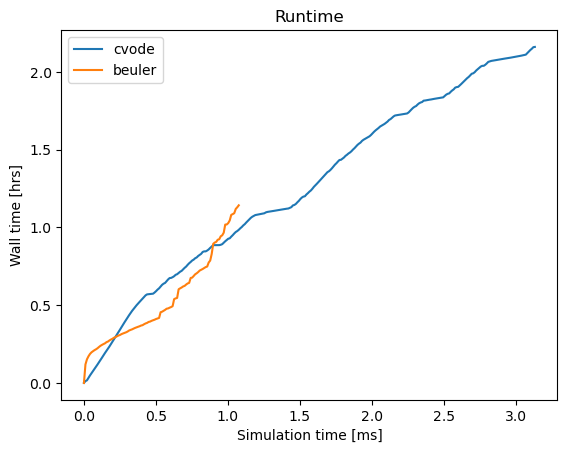

In [18]:
fig, ax = plt.subplots()

for i, case in enumerate(toload):
    ds = casestore[case["name"]].ds
    ax.plot(ds["t"]*100, ds["wtime"].cumsum()/3600, label = case["name"])
    
ax.legend()
ax.set_xlabel("Simulation time [ms]") ; ax.set_ylabel("Wall time [hrs]")
ax.set_title("Runtime")

# Contour comparison

CVODE
beuler


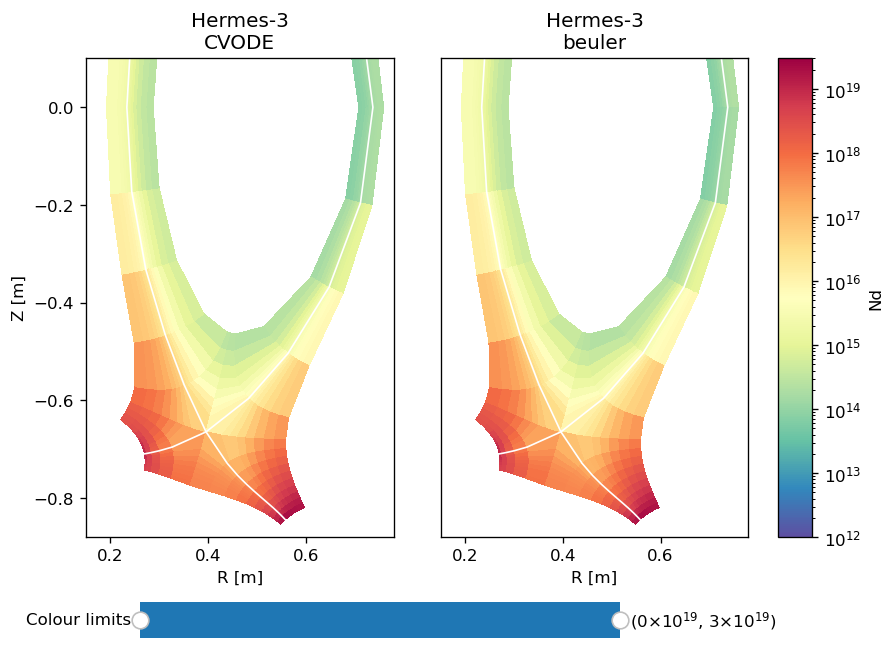

In [13]:
v = viewer_2d(
    "Nd",
    {
        "CVODE"  : {"code":"hermes", "ds" : casestore["cvode"].ds.isel(t=-1)},
        "beuler" : {"code":"hermes", "ds" : casestore["beuler"].ds.isel(t=-1)},
        
    },
    logscale = True,
    vmin = 1e12,
    vmax = 3e19,
)zz

In [48]:
for name in casestore:
    ds = casestore[name].ds
    ds["Vd"] = ds["NVd"] / (constants("mass_p")*2 * ds["Nd"])
    ds["Rd+_ex"] = abs(ds["Rd+_ex"])
    for species in ["d+", "d"]:
        
        ds[f"Pdyn{species}"] = ds[f"NV{species}"] * ds[f"V{species}"]
        ds[f"Ptot{species}"] = ds[f"P{species}"] + ds[f"Pdyn{species}"]

# Profile comparison

c:\Users\mikek\OneDrive\Project\python-packages\sdtools\hermes3\plotting.py:730: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  axes[i].set_yscale(scale)


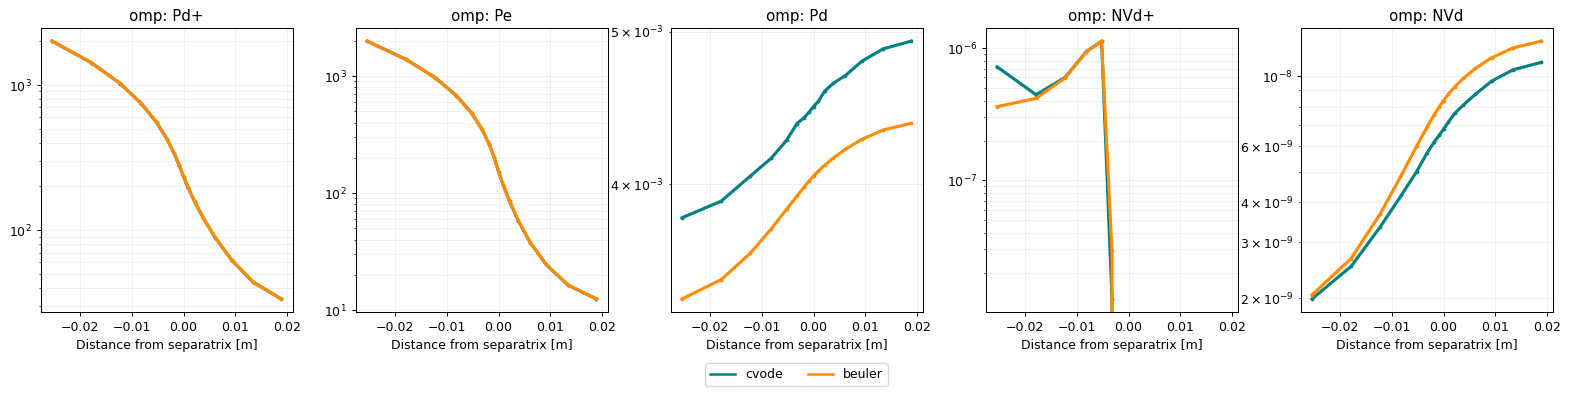

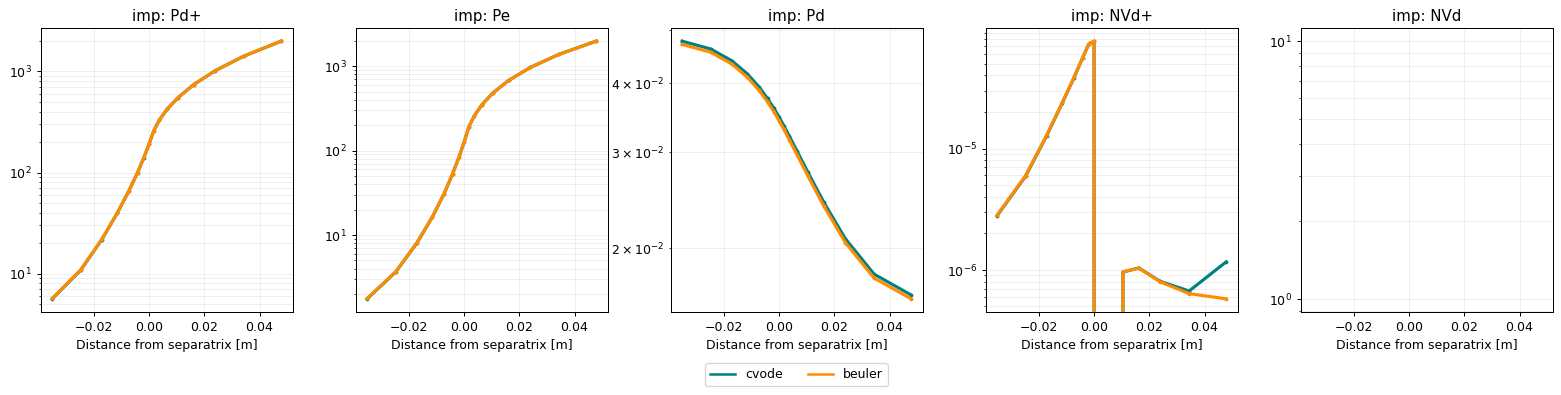

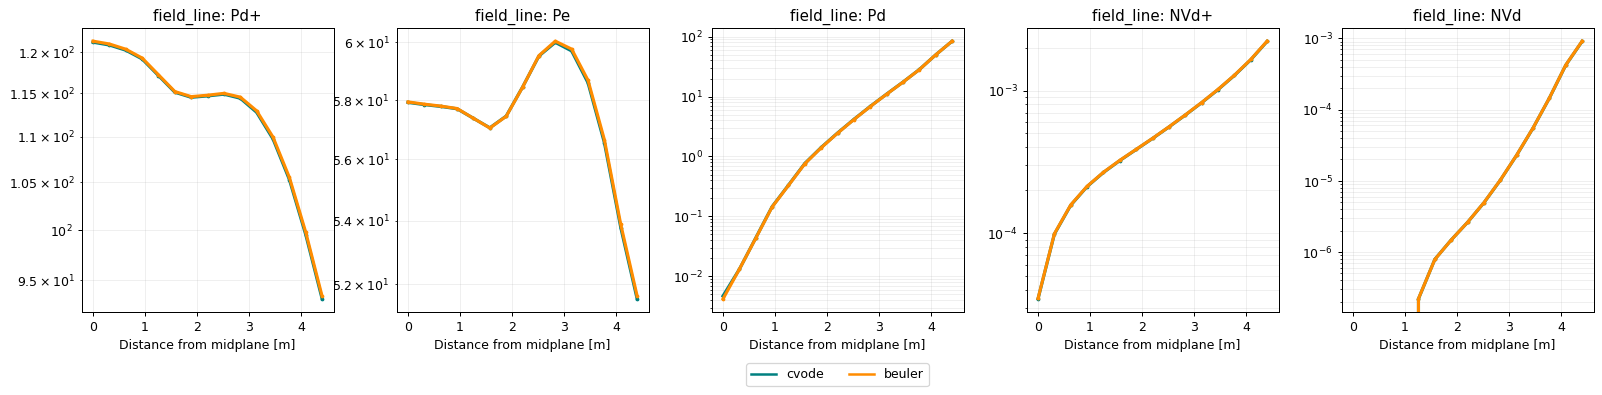

In [20]:
cases = dict()

for name in ["cvode", "beuler"]:
    cases[name] = casestore[name].ds.isel(t=-1, x = slice(2,-2))

lineplot(
    cases = cases,
    
    clean_guards = False,
    regions = ["omp", "imp", "field_line"],
    # params = ["Td+", "Te", "Td", "Ne", "Nd"],
    params = ["Pd+", "Pe", "Pd", "NVd+", "NVd"],
    # params = ["Pd+", "Pdynd+", "Ptotd+", "Ne"],
    # params = ["Pd", "Pdynd", "Ptotd", "Nd"],
    # params = ["Td+", "Te", "Td"],
    # params = ["Ne", "Nd", "NVd+", "NVd"],
    # params = ["Ne", "Nd", "Sd+_iz"],
    dpi = 90
)

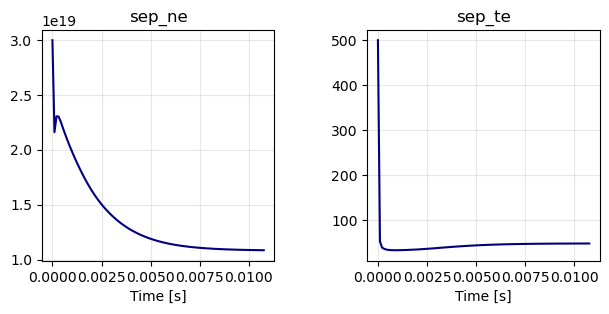

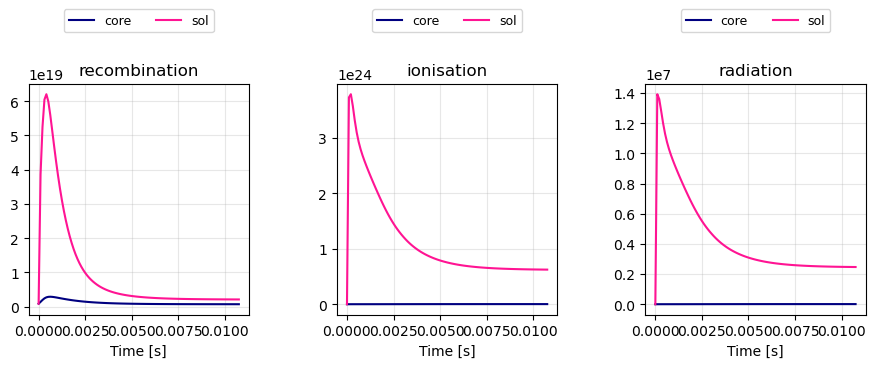

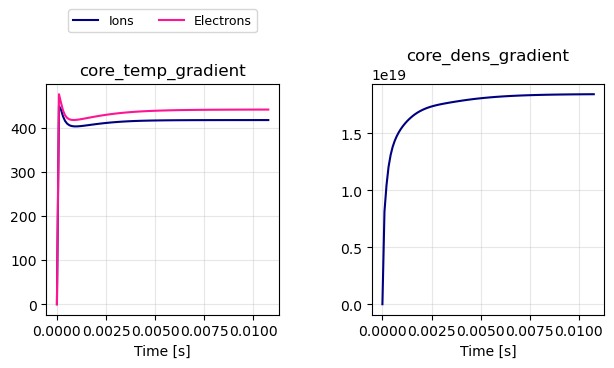

In [22]:
Monitor(casestore["beuler"], [["sep_ne", "sep_te"],
               ["recombination", "ionisation", "radiation"],
               ["core_temp_gradient", "core_dens_gradient"],
            #    ["cvode_order", "cvode_evals", "cvode_fails"]
               ])
# Monitor(case, [["recombination", "ionisation", "radiation"]])

ValueError: min() arg is an empty sequence

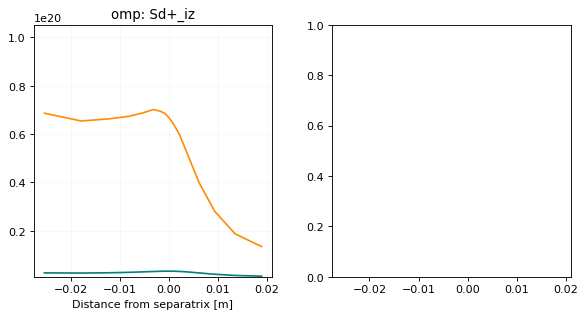

In [60]:
plt.close("all")
lineplot_compare(
    cases = { 
    "Hermes-3: pre-fixes" : dict(data=hr["x3a1-mxorder3-1e-4rtol"], color = "teal"),
    "Hermes-3: post-fixes" : dict(data=hr["x3a2-post_1D_fixes"], color = "darkorange")
    },
    colors = ["teal", "darkorange", "black", "red", "deeppink", "darkorange"],
    regions = ["omp", "imp", "outer_lower"], params = ["Sd+_iz", "Sd+_rec"],
    mode = "log",
    dpi = 80,
    set_xlim = False,
)